In [19]:
from torch import nn

In [20]:
from torch import tensor

In [21]:
m = tensor([[1,2,3],[4,5,6],[7,8,9]])

In [29]:
n = tensor([[10],[20],[30]])

In [31]:
%timeit -n 10 t2=m.matmul(m)

The slowest run took 139.64 times longer than the fastest. This could mean that an intermediate result is being cached.
53.1 µs ± 124 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
m@m

tensor([[ 30,  36,  42],
        [ 66,  81,  96],
        [102, 126, 150]])

In [34]:
import torch

In [35]:
torch.matmul(m,m)

tensor([[ 30,  36,  42],
        [ 66,  81,  96],
        [102, 126, 150]])

In [41]:
[1,2,3][np.round(0.02*100).astype(int)]

3

In [30]:
m+n

tensor([[11, 12, 13],
        [24, 25, 26],
        [37, 38, 39]])

In [ ]:
nn.functional.nll_loss

In [1]:
# -*- coding: utf-8 -*
from __future__ import print_function
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import sys
from time import time
import json
import os
import platform
import random
import requests
import pandas as pd
import numpy
import numpy as np

from PIL import Image
from flyai.processor.base import Base
from flyai.processor.download import check_download
from flyai.utils.yaml_helper import Yaml
from flyai.utils import read_data

from path import DATA_PATH

import librosa
import scipy.io.wavfile as wavfile

In [2]:
def Csv(config,line=""):
    if line is "":
        line = True
    else:
        line = False
    train_path = check_download(config['train_url'], DATA_PATH, is_print=line)
    data = read_data.read(train_path)
    val_path = check_download(config['test_url'], DATA_PATH, is_print=line)
    val = read_data.read(val_path)
    return data,val

def load_csv(custom_source=None):
    yaml = Yaml()
    try:
        f = open(os.path.join(sys.path[0], 'train.json'))
        line = f.readline().strip()
    except IOError:
        line = ""

    postdata = {'id': yaml.get_data_id(),
                'env': line,
                'time': time(),
                'sign': random.random(),
                'goos': platform.platform()}

    try:
        servers = yaml.get_servers()
        r = requests.post(servers[0]['url'] + "/dataset", data=postdata)
        source = json.loads(r.text)
    except:
        source = None

    if source is None:
        trn,val = Csv({'train_url': os.path.join(DATA_PATH, "dev.csv"),'test_url': os.path.join(DATA_PATH, "dev.csv")}, line)
    elif 'yaml' in source:
        source = source['yaml']
        if custom_source is None:
            trn,val = Csv(source['config'], line)
        else:
            source = custom_source
    else:
        if not os.path.exists(os.path.join(DATA_PATH, "train.csv")) and not os.path.exists(
                os.path.join(DATA_PATH, "test.csv")):
            raise Exception("invalid data id!")
        else:
            trn,val = Csv({'train_url': os.path.join(DATA_PATH, "train.csv"),'test_url': os.path.join(DATA_PATH, "test.csv")}, line)
    print(source)
    return trn,val


def load_data(combine=True,summary=True):
    trn,val = load_csv()
    if combine:
        trn = pd.concat([trn,val])
    if summary:
        data_summary = trn.describe()
        for k in range(data_summary.shape[1]):
            print(list(data_summary.iloc[:,k]))
        for i in range(1,trn.shape[1]):
            print(trn.iloc[:,i].value_counts()[:10])
    return trn, val

In [3]:
from processor import ImageLabel,load_data

In [4]:
a = ImageLabel('data/input',val)

NameError: name 'val' is not defined

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[2].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)

In [7]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [14]:
frames=41
bands=60
fn = 'data/input/wav/104.wav'
window_size = 512 * (frames - 1)
log_specgrams = []
labels = []
sound_clip,s = librosa.load(fn)
#label = fn.split('/')[2].split('-')[1]
for (start,end) in windows(sound_clip,window_size):
    if(len(sound_clip[start:end]) == window_size):
        signal = sound_clip[start:end]
        melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
        logspec = librosa.amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        log_specgrams.append(logspec)
        mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    
        #labels.append(label)

In [15]:
logspec.shape

(1, 2460)

In [17]:
mfcc.shape

(1, 2460)

In [ ]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[2].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    labels.append(label)         
    features = np.asarray(mfccs).reshape(len(mfccs),frames,bands)
    return np.array(features), np.array(labels,dtype = np.int)

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print "Error encountered while parsing file: ", fn
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

In [6]:
val

,ID,Class
0,wav/7278.wav,street_music
1,wav/8142.wav,engine_idling
2,wav/1868.wav,drilling
3,wav/2260.wav,air_conditioner
4,wav/4412.wav,dog_bark
5,wav/7930.wav,siren
6,wav/455.wav,siren
7,wav/5493.wav,air_conditioner
8,wav/6198.wav,siren
9,wav/8282.wav,engine_idling


In [5]:
trn,val = load_data()

dev.zip total size:  75 MB


[                                                  ] 1%

[#                                                 ] 2%

[#                                                 ] 3%

[##                                                ] 4%

[##                                                ] 5%

[##                                                ] 5%

[###                                               ] 6%

[###                                               ] 7%

[####                                              ] 8%

[####                                              ] 9%

[#####                                             ] 10%

[#####                                             ] 11%

[######                                            ] 12%

[######                                            ] 13%

[#######                                           ] 14%

[#######                                           ] 15%

[#######                                           ] 15%

[########                                          ] 16%

[########                                          ] 17%

[#########                                         ] 18%

[#########                                         ] 19%

[##########                                        ] 20%

[##########                                        ] 21%

[###########                                       ] 22%

[###########                                       ] 23%

[############                                      ] 24%

[############                                      ] 24%

[#############                                     ] 27%

[##############                                    ] 28%

[##############                                    ] 29%

[###############                                   ] 30%

[###############                                   ] 31%

[################                                  ] 32%

[################                                  ] 33%

[#################                                 ] 34%

[#################                                 ] 34%

[#################                                 ] 35%

[##################                                ] 36%

[##################                                ] 37%

[###################                               ] 38%

[###################                               ] 39%

[####################                              ] 40%

[####################                              ] 41%

[#####################                             ] 42%

[#####################                             ] 43%

[######################                            ] 44%

[######################                            ] 45%

[#######################                           ] 46%

[#######################                           ] 46%

[#######################                           ] 47%

[########################                          ] 48%

[########################                          ] 49%

[#########################                         ] 50%

[#########################                         ] 51%

[##########################                        ] 52%

[##########################                        ] 53%

[###########################                       ] 54%

[###########################                       ] 55%

[############################                      ] 56%

[############################                      ] 57%

[#############################                     ] 58%

[#############################                     ] 58%

[##################################################] 100%{'id': 'UrbanSoundClassification', 'type': 'csv', 'config': {'train_url': 'https://dataset.flyai.com/dataset/UrbanSoundClassification/dev.zip', 'test_url': 'https://dataset.flyai.com/dataset/UrbanSoundClassification/dev.zip'}}
[200, 100, 'wav/1825.wav', 2]
[200, 10, 'street_music', 28]
street_music        28
dog_bark            26
engine_idling       26
drilling            26
siren               26
air_conditioner     22
jackhammer          18
children_playing    12
car_horn            10
gun_shot             6
Name: Class, dtype: int64


In [6]:
val.head()

,ID,Class
0,wav/7278.wav,street_music
1,wav/8142.wav,engine_idling
2,wav/1868.wav,drilling
3,wav/2260.wav,air_conditioner
4,wav/4412.wav,dog_bark


In [29]:
read_wav("wav/7278.wav",3).shape

(66150,)

In [ ]:
y, _ = librosa.load()

In [7]:
def read_wav(f,dr=2):
    sr = 22050
    y_len = sr*dr
    try:
        y,_ = librosa.load(os.path.join(DATA_PATH, f))
        yl = len(y)
        if yl<y_len:
            y = np.tile(y,np.ceil(y_len/yl).astype(int))[:y_len]
        elif yl>y_len:
            y = y[:y_len]
    except:
        y = np.zeros(y_len,dtype=np.float32)
        print("error: loading wav")
    return y

In [8]:
ys = [read_wav(f) for f in val.ID]

In [23]:
ys[0].shape

(44100,)

In [30]:
librosa.feature.melspectrogram(read_wav("wav/7278.wav",3)).shape

(128, 130)

In [56]:
len(np.tile(ys[0][:51],np.ceil(len(ys[0])/51).astype(int)))

88230

In [45]:
np.zeros(100,dtype=np.float32)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [35]:
pss = [librosa.feature.melspectrogram(y) for y in ys]

In [16]:
duration = 2.97
sr = 22050
y, sr = librosa.load(os.path.join(DATA_PATH, 'wav/8142.wav'))
#sr, y = wavfile.read(os.path.join(DATA_PATH, ID))
ps = librosa.feature.melspectrogram(y=y, sr=sr)
dur = librosa.get_duration(y=y)

In [47]:
len(y)/22050

4.0

In [46]:
(128*173)

22144

In [26]:
16097/(128*32)

3.929931640625

(array([   79.,   308.,   785.,  5487., 37985., 38169.,  4216.,   809.,
          313.,    49.]),
 array([-0.7326432 , -0.5855803 , -0.43851736, -0.29145443, -0.14439152,
         0.00267139,  0.1497343 ,  0.29679722,  0.44386014,  0.5909231 ,
         0.73798597], dtype=float32),
 <a list of 10 Patch objects>)

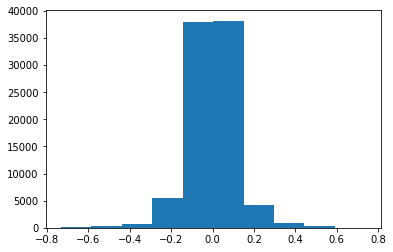

In [23]:
plt.hist(y)

In [ ]:
librosa.spectrums

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

AttributeError: module 'librosa' has no attribute 'display'

In [17]:
y,sr,ps,dur

(array([ 0.03276835,  0.0533511 ,  0.03499123, ...,  0.08782886,
         0.10849788, -0.02714667], dtype=float32),
 22050,
 array([[1.32750324e+01, 3.14319558e+01, 3.39747016e+01, ...,
         4.15675446e+00, 1.25735951e+01, 4.29210735e+01],
        [1.16522342e+01, 2.37878048e+01, 1.68176149e+01, ...,
         1.19393119e+01, 3.57349916e+01, 2.72583129e+01],
        [1.98963005e+00, 3.09912157e+00, 2.15885310e+00, ...,
         1.65102459e+00, 6.23396414e+00, 5.46688636e+00],
        ...,
        [3.00675160e-02, 1.35023275e-02, 7.58081202e-03, ...,
         1.81350249e-02, 1.16912228e-02, 2.36763050e-02],
        [1.12863423e-02, 5.38143075e-03, 3.10457891e-03, ...,
         1.00367249e-02, 3.16877815e-03, 7.07587540e-03],
        [5.25994236e-04, 3.53461483e-04, 3.46575529e-04, ...,
         8.49931063e-04, 3.23305636e-04, 1.14278504e-03]]),
 4.0)

In [18]:
y.shape

(88200,)

In [19]:
ps.shape

(128, 173)

In [12]:
y,sr,ps,dur

(array([0.00587734, 0.00786727, 0.00599515, ..., 0.0003803 , 0.00030687,
        0.00026223], dtype=float32),
 22050,
 array([[3.12966526e-02, 3.60512561e-01, 4.95549077e-01, ...,
         1.95445126e-04, 5.08089295e-04, 5.50785230e-04],
        [6.43087680e-02, 9.79346513e-02, 2.51188667e-01, ...,
         7.92456685e-04, 1.20819759e-03, 7.81764720e-04],
        [1.55014114e-02, 3.69624997e-02, 3.58083519e-02, ...,
         1.67481823e-03, 8.74616006e-04, 4.76022692e-04],
        ...,
        [3.10609830e-06, 3.08788395e-06, 3.87144322e-06, ...,
         1.22870628e-07, 6.74823242e-08, 3.84950678e-08],
        [3.11330796e-06, 1.66823773e-06, 1.58886565e-06, ...,
         3.76389088e-08, 2.84127432e-08, 1.61564400e-08],
        [3.39363665e-06, 9.17666041e-07, 1.19783241e-07, ...,
         3.78884140e-09, 2.30504201e-09, 7.08208472e-10]]),
 4.0)

In [15]:
y.shape[0]/22050

4.0

In [13]:
ps.shape

(128, 173)

In [10]:
128*128

16384

In [ ]:
if (round(dur) < duration):
    input_length = sr * duration
    offset = len(y) - round(input_length)
    y = librosa.util.fix_length(y, round(input_length))

ps = librosa.feature.melspectrogram(y=y, sr=sr)
if ps.shape != (128, 128):
    return np.zeros((1,128, 128))

return ps.reshape((1,128, 128))

In [ ]:
list_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
                            'drilling',
                            'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
# Map integer value to text labels
label_to_int = {k: v for v, k in enumerate(list_labels)}
def make_weights_for_balanced_classes(labels, nclasses):                        
    count = [0] * nclasses                                                      
    labels = [label_to_int[i] for i in labels]
    for item in labels:                                                         
        count[item] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):
        if count[i]!=0:
            weight_per_class[i] = N/np.sqrt(count[i])                                 
    weight = [0] * len(labels)                                              
    for idx, val in enumerate(labels):                                          
        weight[idx] = weight_per_class[val]                                  
    return weight 

class Processor(Base):
    # 该参数需要与app.yaml的Model的input-->columns->name 一一对应
    def __init__(self):
        self.list_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
                            'drilling',
                            'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
        # Map integer value to text labels
        self.label_to_int = {k: v for v, k in enumerate(self.list_labels)}

        # map integer to text labels
        self.int_to_label = {v: k for k, v in self.label_to_int.items()}
    def input_x(self, ID):
        '''
        参数为csv中作为输入x的一条数据，该方法会被Dataset多次调用
        '''
        a

    # 该参数需要与app.yaml的Model的output-->columns->name 一一对应
    def input_y(self, Class):
        '''
        参数为csv中作为输入y的一条数据，该方法会被Dataset多次调用
        '''
        return self.label_to_int[Class]

    
    
    def output_y(self, datas):
        '''
        验证时使用，把模型输出的y转为对应的结果
        '''
        labels=[]
        for data in datas:
            labels.append(self.int_to_label[numpy.argmax(data)])
        return labels



class ImageLabel(Dataset):
    """Two colnum (image_path,label)

    Args:
        root (string): Root directory of dataset where directory
            ``caltech256`` exists or will be saved to if download is set to True.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    def __init__(self, root,df,transform=None, target_transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        self.list_labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
                            'drilling',
                            'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
        # Map integer value to text labels
        self.label_to_int = {k: v for v, k in enumerate(self.list_labels)}

        # map integer to text labels
        self.int_to_label = {v: k for k, v in self.label_to_int.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        ID,label=self.df.iloc[index]
        duration = 2.97
        sr = 22050
      
        #y, sr = librosa.load(os.path.join(DATA_PATH, ID), duration=duration, sr=sr)
        sr, y = wavfile.read(os.path.join(DATA_PATH, ID))
        print(sr,y)
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        dur = librosa.get_duration(y=y)

        if (round(dur) < duration):
            input_length = sr * duration
            offset = len(y) - round(input_length)
            y = librosa.util.fix_length(y, round(input_length))

        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        print(ps)

        if ps.shape != (128, 128):
            ps = np.zeros((128, 128,1))
        ps = ps.reshape((128,128,1))
        if self.transform is not None:
            image = self.transform(ps)

        if self.target_transform is not None:
            label = self.target_transform(label)
        return image,self.label_to_int[label]
        
